In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [2]:
PROJECT = "machine-learning-1234"
BUCKET = "machine-learning-1234-bucket"
REGION = "us-central1"

# Import os environment variables
os.environ["PROJECT"] = PROJECT
os.environ["BUCKET"] =  BUCKET
os.environ["REGION"] = REGION
os.environ["TFVERSION"] = "1.15"
os.environ["PYTHON_VERSION"] = "3.5"

In [14]:
arguments = {}
# Image parameters
arguments["height"] = 1024
arguments["width"] = 1024
arguments["depth"] = 3

## Write

In [15]:
# %%bash
# python3 jpeg_to_tfrecord.py \
#     --train_csv gs://${BUCKET}/gan/celeba-hq/celeba_hq_file_list.csv \
#     --project_id ${PROJECT} \
#     --output_dir gs://${BUCKET}/gan/pgan/data/celeba_hq

## Read

In [16]:
def print_obj(function_name, object_name, object_value):
    """Prints enclosing function, object name, and object value.

    Args:
        function_name: str, name of function.
        object_name: str, name of object.
        object_value: object, value of passed object.
    """
#     pass
    print("{}: {} = {}".format(function_name, object_name, object_value))

In [29]:
def decode_example(protos, params):
    """Decodes TFRecord file into tensors.

    Given protobufs, decode into image and label tensors.

    Args:
        protos: protobufs from TFRecord file.
        params: dict, user passed parameters.

    Returns:
        Image and label tensors.
    """
    # Create feature schema map for protos.
    features = {
        "image_raw": tf.FixedLenFeature(shape=[], dtype=tf.string)
    }

    # Parse features from tf.Example.
    parsed_features = tf.parse_single_example(
        serialized=protos, features=features
    )
    print_obj("\ndecode_example", "features", features)

    # Convert from a scalar string tensor (whose single string has
    # length height * width * depth) to a uint8 tensor with shape
    # [height * width * depth].
    image = tf.image.decode_jpeg(
        contents=parsed_features["image_raw"], channels=3
    )
    print_obj("decode_example", "image", image)

    # Reshape flattened image back into normal dimensions.
    image = tf.reshape(
        tensor=image,
        shape=[params["height"], params["width"], params["depth"]]
    )
    print_obj("decode_example", "image", image)

    # Convert from [0, 255] -> [-1.0, 1.0] floats.
    image_scaled = tf.cast(x=image, dtype=tf.float32) * (2. / 255) - 1.0
    print_obj("decode_example", "image", image)

    return {"image": image, "image_scaled": image_scaled}


def read_dataset(filename, mode, batch_size, params):
    """Reads CSV time series data using tf.data, doing necessary preprocessing.

    Given filename, mode, batch size, and other parameters, read CSV dataset
    using Dataset API, apply necessary preprocessing, and return an input
    function to the Estimator API.

    Args:
        filename: str, file pattern that to read into our tf.data dataset.
        mode: The estimator ModeKeys. Can be TRAIN or EVAL.
        batch_size: int, number of examples per batch.
        params: dict, dictionary of user passed parameters.

    Returns:
        An input function.
    """
    def _input_fn():
        """Wrapper input function used by Estimator API to get data tensors.

        Returns:
            Batched dataset object of dictionary of feature tensors and label
                tensor.
        """
        # Create list of files that match pattern.
        file_list = tf.gfile.Glob(filename=filename)

        # Create dataset from file list.
        dataset = tf.data.TFRecordDataset(
            filenames=file_list, num_parallel_reads=40
        )

        # Shuffle and repeat if training with fused op.
        if mode == tf.estimator.ModeKeys.TRAIN:
            dataset = dataset.apply(
                tf.contrib.data.shuffle_and_repeat(
                    buffer_size=50 * batch_size,
                    count=None  # indefinitely
                )
            )

        # Decode CSV file into a features dictionary of tensors, then batch.
        dataset = dataset.apply(
            tf.contrib.data.map_and_batch(
                map_func=lambda x: decode_example(
                    protos=x,
                    params=params
                ),
                batch_size=batch_size,
                num_parallel_calls=4
            )
        )

        # Prefetch data to improve latency.
        dataset = dataset.prefetch(buffer_size=2)

        # Create a iterator, then get batch of features from example queue.
        batched_dataset = dataset.make_one_shot_iterator().get_next()

        return batched_dataset
    return _input_fn


In [33]:
def try_out_input_function(arguments, print_features=False):
    """Trys out input function for testing purposes.

    Args:
        arguments: dict, user passed parameters.
        print_out: bool, whether to print features or not.
    Returns:
        Dictionary of feature arrays and array of labels.
    """
    with tf.Session() as sess:
        fn = read_dataset(
            filename=arguments["filename"],
            mode=tf.estimator.ModeKeys.EVAL,
            batch_size=8,
            params=arguments
        )

        features = sess.run(fetches=fn())
        print("features[image].shape = {}".format(features["image"].shape))
        if print_features:
            print("features = \n{}".format(features))

    return features


In [34]:
def plot_images(images):
    """Plots images.

    Args:
        images: np.array, array of images of
            [num_images, image_size, image_size, num_channels].
    """
    num_images = len(images)

    plt.figure(figsize=(20, 20))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
    plt.show()


In [41]:
arguments["filename"] = "gs://machine-learning-1234-bucket/gan/pgan/data/celeba_hq/train-00001-of-00080"
features = try_out_input_function(arguments, print_features=False)


decode_example: features = {'image_raw': FixedLenFeature(shape=[], dtype=tf.string, default_value=None)}
decode_example: image = Tensor("DecodeJpeg:0", shape=(?, ?, 3), dtype=uint8)
decode_example: image = Tensor("Reshape:0", shape=(1024, 1024, 3), dtype=uint8)
decode_example: image = Tensor("Reshape:0", shape=(1024, 1024, 3), dtype=uint8)
features[image].shape = (8, 1024, 1024, 3)



decode_example: features = {'image_raw': FixedLenFeature(shape=[], dtype=tf.string, default_value=None)}
decode_example: image = Tensor("DecodeJpeg:0", shape=(?, ?, 3), dtype=uint8)
decode_example: image = Tensor("Reshape:0", shape=(1024, 1024, 3), dtype=uint8)
decode_example: image = Tensor("Reshape:0", shape=(1024, 1024, 3), dtype=uint8)
features[image].shape = (8, 1024, 1024, 3)


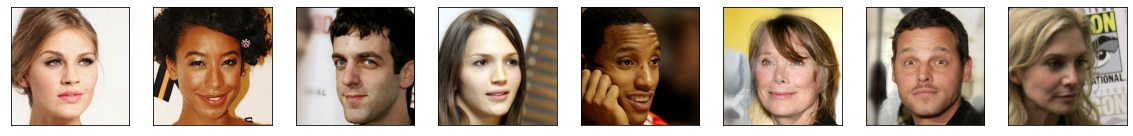

In [42]:
features = try_out_input_function(arguments, print_features=False)
plot_images(features["image"])